In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ticket/data.csv


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/kaggle/input/ticket/data.csv')
df.drop(columns=['Unnamed: 0'])
df['sentence'] = df['clean_subject'] + ' ' + df['clean_description']

In [4]:
data = df[['ticket_type','sentence']]
data = data[data['ticket_type'] != 'Problem'] #Drop Class Problem
data.dropna(subset=['sentence'], inplace=True)
data['ticket_type'].value_counts(normalize = True)

ticket_type
Request     0.584616
Incident    0.415384
Name: proportion, dtype: float64

### **package**

In [5]:
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.30.1
    Uninstalling accelerate-0.30.1:
      Successfully uninstalled accelerate-0.30.1


In [6]:
!pip install transformers torch

In [7]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

2024-07-03 09:36:58.129205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 09:36:58.129330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 09:36:58.257281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['sentence'], data['ticket_type'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['ticket_type'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.3,
                                                                stratify=temp_labels)

<Axes: >

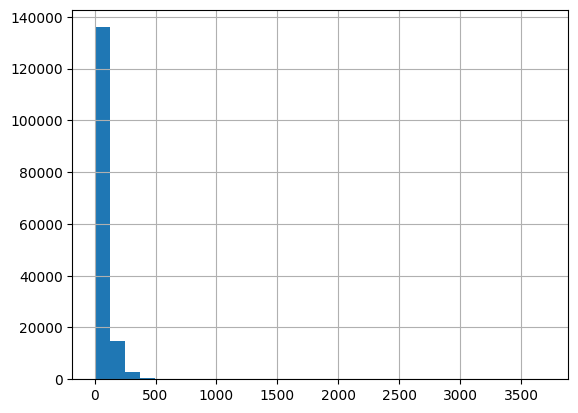

In [9]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [10]:
from transformers import BertModel, BertTokenizer
bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [11]:
from transformers import BertTokenizer
import torch
# Define a function to preprocess text for BERT
def preprocess_text(texts, max_length=100):
    # Tokenize input texts
    tokens = tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        pad_to_max_length=True,
        truncation=True
    )

    # Convert tokens to PyTorch tensors
    seq = torch.tensor(tokens['input_ids'], dtype=torch.long)
    mask = torch.tensor(tokens['attention_mask'], dtype=torch.long)

    return seq, mask

In [12]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 100,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 100,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 100,
    pad_to_max_length=True,
    truncation=True
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the labels
train_labels = le.fit_transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

In [14]:
import torch

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'], dtype=torch.long)
train_mask = torch.tensor(tokens_train['attention_mask'], dtype=torch.long)
train_y = torch.tensor(train_labels, dtype=torch.long)

val_seq = torch.tensor(tokens_val['input_ids'], dtype=torch.long)
val_mask = torch.tensor(tokens_val['attention_mask'], dtype=torch.long)
val_y = torch.tensor(val_labels, dtype=torch.long)

test_seq = torch.tensor(tokens_test['input_ids'], dtype=torch.long)
test_mask = torch.tensor(tokens_test['attention_mask'], dtype=torch.long)
test_y = torch.tensor(test_labels, dtype=torch.long)

In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Batch size
batch_size = 16

# Create TensorDataset for training data
train_data = TensorDataset(train_seq, train_mask, train_y)
# Create a RandomSampler for training data
train_sampler = RandomSampler(train_data)
# Create DataLoader for training data
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [16]:
!pip install captum

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.0 MB/s eta 0:00:00


## **define**

In [17]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from captum.attr import IntegratedGradients

In [18]:
# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)  # Adjusted for 2 classes (0 and 1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_hs = outputs.pooler_output
        x = self.dropout(cls_hs)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Initialize the BERT architecture with the pre-trained BERT
model = BERT_Arch(bert)
model.to(device)

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [19]:
# optimizer from hugging face transformers
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print('Class Weights:', class_weights)

Class Weights: [1.20371091 0.85525952]


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights)
epochs = 10
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
# Function to calculate accuracy
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
import time
# Function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        optimizer.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        preds = preds.detach().cpu().numpy()
        labels = labels.cpu().numpy()
        total_accuracy += accuracy(preds, labels)

    avg_loss = total_loss / len(train_dataloader)
    avg_accuracy = total_accuracy / len(train_dataloader)

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)

    return avg_loss, avg_accuracy

In [22]:
# Function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    model.eval()

    total_loss, total_accuracy = 0, 0
    for step, batch in enumerate(val_dataloader):

        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():

            # Model predictions
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()

            preds = preds.detach().cpu().numpy()
            labels = labels.cpu().numpy()
            total_accuracy += accuracy(preds, labels)

    avg_loss = total_loss / len(val_dataloader)
    avg_accuracy = total_accuracy / len(val_dataloader)

    val_losses.append(avg_loss)
    val_accuracies.append(avg_accuracy)

    return avg_loss, avg_accuracy

## **train**

In [23]:
# Training and evaluation loop
for epoch in range(epochs):
    print(f'\n Epoch {epoch + 1} / {epochs}')
    train_loss, train_acc = train()
    print(f'Training Loss: {train_loss:.3f}, Training Accuracy: {train_acc:.3f}')

    val_loss, val_acc = evaluate()
    print(f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.3f}')


 Epoch 1 / 10
  Batch    50  of  9,663.
  Batch   100  of  9,663.
  Batch   150  of  9,663.
  Batch   200  of  9,663.
  Batch   250  of  9,663.
  Batch   300  of  9,663.
  Batch   350  of  9,663.
  Batch   400  of  9,663.
  Batch   450  of  9,663.
  Batch   500  of  9,663.
  Batch   550  of  9,663.
  Batch   600  of  9,663.
  Batch   650  of  9,663.
  Batch   700  of  9,663.
  Batch   750  of  9,663.
  Batch   800  of  9,663.
  Batch   850  of  9,663.
  Batch   900  of  9,663.
  Batch   950  of  9,663.
  Batch 1,000  of  9,663.
  Batch 1,050  of  9,663.
  Batch 1,100  of  9,663.
  Batch 1,150  of  9,663.
  Batch 1,200  of  9,663.
  Batch 1,250  of  9,663.
  Batch 1,300  of  9,663.
  Batch 1,350  of  9,663.
  Batch 1,400  of  9,663.
  Batch 1,450  of  9,663.
  Batch 1,500  of  9,663.
  Batch 1,550  of  9,663.
  Batch 1,600  of  9,663.
  Batch 1,650  of  9,663.
  Batch 1,700  of  9,663.
  Batch 1,750  of  9,663.
  Batch 1,800  of  9,663.
  Batch 1,850  of  9,663.
  Batch 1,900  of  9,66

## **model performance**

In [24]:
# Assuming your model variable is `model` and it's already trained
torch.save(model.state_dict(), 'model.pt')

In [25]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

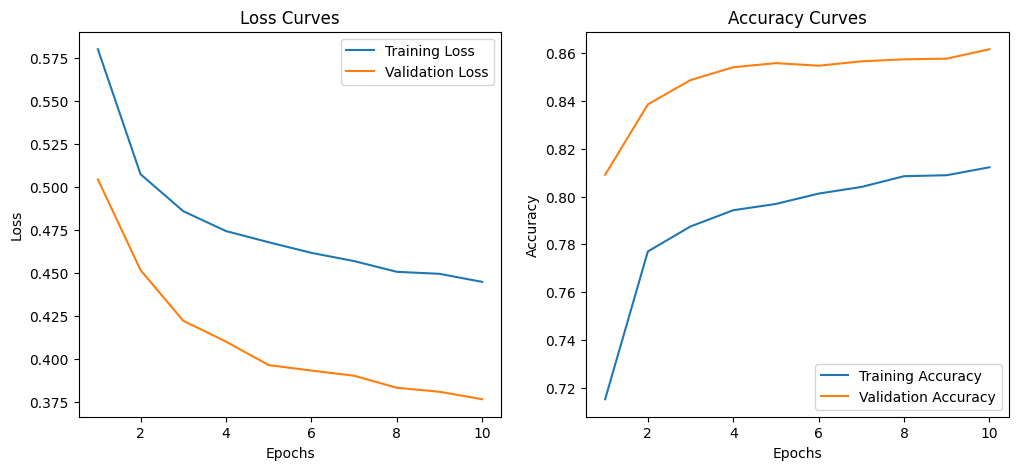

In [26]:
plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [27]:
batch_size = 16

# Initialize lists to store predictions
preds_list = []

# Iterate over batches of test data
for i in range(0, len(test_seq), batch_size):
    # Get batch tensors
    batch_seq = test_seq[i:i+batch_size].to(device)
    batch_mask = test_mask[i:i+batch_size].to(device)

    # Perform inference
    with torch.no_grad():
        batch_preds = model(batch_seq, batch_mask)
        batch_preds = batch_preds.detach().cpu().numpy()

    # Append batch predictions to list
    preds_list.append(batch_preds)

# Concatenate all batch predictions
preds = np.concatenate(preds_list, axis=0)

# Calculate final predictions
preds = np.argmax(preds, axis=1)

In [28]:
# Decode encoded labels to original labels
original_labels = le.inverse_transform(test_y)

# Convert original_labels to integers if they are strings
if isinstance(original_labels[0], str):
    original_labels = le.transform(original_labels)

# Print classification report with original labels
print(classification_report(original_labels, preds))

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      8257
           1       0.84      0.96      0.89     11620

    accuracy                           0.87     19877
   macro avg       0.88      0.85      0.86     19877
weighted avg       0.87      0.87      0.86     19877



In [29]:
# Load the saved model weights
model.load_state_dict(torch.load('/kaggle/working/model.pt'))
model.eval()  # Set the model to evaluation mode

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [30]:
from sklearn.preprocessing import LabelEncoder

# Assuming you used LabelEncoder to encode your classes
label_encoder = LabelEncoder()
label_encoder.fit(data['ticket_type'])

# Print the mapping of classes to integer labels
for class_label, class_index in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f'Class: {class_label}, Encoded as: {class_index}')

Class: Incident, Encoded as: 0
Class: Request, Encoded as: 1


In [31]:
# Example sentences
example_sentences = [
    "รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสารภี", #request
    "Incident baac  inextbaac    inext ตรวจสอบพบวงจร", #incident
    "op cloud   noc ได้รับ alert", #incident
    "ขอยกเลิก user   reset password noc ขอยกเลิก user vpn ตามรูป จาก  user ให้เหลือเง", #request
    "กรุณาส่งรายละเอียดด้านล่างให้กับ Team [INET_CSIRT] และ cc [INET_CO-CSIRT] เพื่อตรวจสอบและแก้ไขปัญหาต่อไป", #request
    "ขอยกเลิก user vpn ตามรูป จาก 5 user ให้เหลือเพียง 2 user และทำการ reset password ให้หน่อยครับเนื่องจากต้องการ ดึง user คืนจาก vender ที่ให้ใช้งานอยู่ขอบคุณครับ"
]

# Tokenize and encode the example sentences
inputs = tokenizer(example_sentences, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)
# Predict
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    predictions = torch.argmax(outputs, dim=1)

# Define a dictionary to map class indices to labels
label_mapping = {0: 'Incident', 1: 'Request'}

# Convert predictions to labels
predicted_labels = [label_mapping[label.item()] for label in predictions]

# Print results
for sentence, label in zip(example_sentences, predicted_labels):
    print(f"Email: {sentence}")
    print(f"Ticket_type: {label}")
    print(f"----------------------------------")

Email: รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสารภี
Ticket_type: Request
----------------------------------
Email: Incident baac  inextbaac    inext ตรวจสอบพบวงจร
Ticket_type: Incident
----------------------------------
Email: op cloud   noc ได้รับ alert
Ticket_type: Incident
----------------------------------
Email: ขอยกเลิก user   reset password noc ขอยกเลิก user vpn ตามรูป จาก  user ให้เหลือเง
Ticket_type: Request
----------------------------------
Email: กรุณาส่งรายละเอียดด้านล่างให้กับ Team [INET_CSIRT] และ cc [INET_CO-CSIRT] เพื่อตรวจสอบและแก้ไขปัญหาต่อไป
Ticket_type: Request
----------------------------------
Email: ขอยกเลิก user vpn ตามรูป จาก 5 user ให้เหลือเพียง 2 user และทำการ reset password ให้หน่อยครับเนื่องจากต้องการ ดึง user คืนจาก vender ที่ให้ใช้งานอยู่ขอบคุณครับ
Ticket_type: Request
----------------------------------


In [32]:
from sklearn.model_selection import train_test_split
import torch

# Tokenize and encode the test sentences (first 20 examples)
inputs = tokenizer(test_text[:100].tolist(), padding=True, truncation=True, return_tensors="pt")
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

# Predict
with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    predictions = torch.argmax(outputs, dim=1)
    
# Define a dictionary to map class indices to labels
label_mapping = {0: 'Incident', 1: 'Request'}

# Convert predictions to labels
predicted_labels = [label_mapping[label.item()] for label in predictions]

# Convert test_labels to string based on label_mapping
test_labels_str = [label_mapping[label] for label in test_labels[:100]]

# Calculate accuracy
correct = sum(1 for true_label, predicted_label in zip(test_labels_str, predicted_labels) if true_label == predicted_label)
total = len(test_labels_str)
accuracy = correct / total * 100

print(f"Accuracy on examples: {accuracy:.2f}%")

# Display predictions and true labels
print("\n")
for idx, (sentence, true_label, predicted_label) in enumerate(zip(test_text[:100], test_labels_str, predicted_labels), 1):
    #print(f"Example {idx}:")
    print(f"Sentence: {sentence}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("----------------------------------")

Accuracy on examples: 88.00%


Sentence: p d k  engineering   ขอเปิด port support ขอเปิด port เพิ่มเติม  in out ครับ
True Label: Request
Predicted Label: Request
----------------------------------
Sentence: noc ได้รับ alert   system notification from fi aci idc  b   environment major         gmt   thermal condition on chassis  is upper non recoverable เมื่อ  march      am af ssivl feffb       gmt   ucs  series fabric interconnect  n af ssivl feffb  true true false        gmt   thermal condition on chassis  is upper non recoverable environment major cisco ucs  series fabric interconnect inet srb inet fi aci idc  b ait   ait ucs fi up   ssivl sam content file
True Label: Incident
Predicted Label: Incident
----------------------------------
Sentence: singha estate mnsp   รบกวนrestore vm spmsdbip     และ ดำเนินการ clone vm ที่ restore ในข้อ noc รบกวนประสานงานทีม nx cloud ดำเนินการดังนี้ค่ะ   restore vm spmsdbip     โดยใช้ back up ของเที่ยงคืน    ที่ผ่าน่ะ   ดำเนินการ clone vm ที่ restore ใ

## **save model**

In [33]:
# Define the path where the model weights will be saved
path = '/kaggle/working/model.pt'

# Save the model weights
torch.save(model.state_dict(), path)

print(f"Model weights saved successfully to '{path}'")

Model weights saved successfully to '/kaggle/working/model.pt'


## **keyBERT**

In [34]:
!pip install keybert

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 9.8 MB/s eta 0:00:00


In [35]:
state_dict = torch.load('/kaggle/working/model.pt', map_location=device)
print(state_dict.keys())

odict_keys(['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output

In [36]:
import torch
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
from keybert import KeyBERT

# Load your fine-tuned BERT model and tokenizer for classification
model_path = '/kaggle/working/model.pt'  # Adjust this path
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = AutoTokenizer.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the BERT model for classification
bert = BertModel.from_pretrained('bert-base-uncased')
model = BERT_Arch(bert)
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Initialize KeyBERT for key phrase extraction
#keybert_model = KeyBERT('distilbert-base-nli-mean-tokens')
#wangchanberta = AutoModel.from_pretrained('airesearch/wangchanberta-base-att-spm-uncased')
#keybert_model = KeyBERT(wangchanberta)
keybert_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')

# Function to classify each key phrase individually
def classify_key_phrase(phrase):
    inputs = tokenizer(phrase, return_tensors='pt', padding=True, truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)

    return predictions.item()  # Assuming your model predicts a single class index

# Function to extract key phrases and classify based on BERT
def extract_key_phrases_and_classify(text):
    # Extract key phrases using KeyBERT
    key_phrases = keybert_model.extract_keywords(text, keyphrase_ngram_range=(1, 3), stop_words=None)

    # Classify each key phrase individually
    key_phrase_classifications = []
    for phrase, score in key_phrases:
        predicted_class = classify_key_phrase(phrase)
        predicted_label = 'Incident' if predicted_class == 0 else 'Request'
        key_phrase_classifications.append((phrase, score, predicted_label))

    return key_phrase_classifications

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [37]:
# Example test sentences
test = [
    "รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสารภี", #request
    "inextbaac    inext ตรวจสอบพบวงจร", #incident
    "OP CLOUD NOC KKC ได้รับ ALEART", #incident
    "ขอยกเลิก user   reset password noc ขอยกเลิก user vpn ตามรูป จาก  user ให้เหลือเง", #request
    "กรุณาส่งรายละเอียดด้านล่างให้กับ Team [INET_CSIRT] และ cc [INET_CO-CSIRT] เพื่อตรวจสอบและแก้ไขปัญหาต่อไป", #request
    "ขอยกเลิก user vpn ตามรูป จาก 5 user ให้เหลือเพียง 2 user และทำการ reset password ให้หน่อยครับเนื่องจากต้องการ ดึง user คืนจาก vender ที่ให้ใช้งานอยู่ขอบคุณครับ"
]

# Classify each test sentence
for idx, sentence in enumerate(test, 1):
    key_phrase_classifications = extract_key_phrases_and_classify(sentence)
    print(f"Example {idx}:")
    print(f"Sentence: {sentence}")
    print("Key Phrases:")
    for phrase, score, predicted_label in key_phrase_classifications:
        print(f"- Phrase: {phrase}, Score: {score}")  # Corrected the formatting here
        print(f"  Predicted Label: {predicted_label}")
    print("----------------------------------")

Example 1:
Sentence: รบกวนเข้าไปเก็บตัวกล่องสัญญาณที่สาขาสารภี
Key Phrases:
- Phrase: สาขาสารภ, Score: 0.6383
  Predicted Label: Request
- Phrase: รบกวนเข าไปเก บต, Score: 0.6143
  Predicted Label: Request
- Phrase: รบกวนเข าไปเก, Score: 0.5932
  Predicted Label: Request
- Phrase: องส ญญาณท สาขาสารภ, Score: 0.588
  Predicted Label: Request
- Phrase: ญญาณท สาขาสารภ, Score: 0.556
  Predicted Label: Request
----------------------------------
Example 2:
Sentence: inextbaac    inext ตรวจสอบพบวงจร
Key Phrases:
- Phrase: inextbaac inext ตรวจสอบพบวงจร, Score: 1.0
  Predicted Label: Request
- Phrase: inext ตรวจสอบพบวงจร, Score: 0.892
  Predicted Label: Request
- Phrase: inextbaac inext, Score: 0.8022
  Predicted Label: Request
- Phrase: inextbaac, Score: 0.7092
  Predicted Label: Request
- Phrase: inext, Score: 0.6342
  Predicted Label: Request
----------------------------------
Example 3:
Sentence: OP CLOUD NOC KKC ได้รับ ALEART
Key Phrases:
- Phrase: kkc, Score: 0.6303
  Predicted Label: Requ